# Testing designer module

Basic data and imports.

In [34]:
import pandas as pd
df = pd.read_csv('../scripts/screen/adam17/out/adam17_random_batch_de650f88-4919-448d-b833-c5f97f0b0e6d.tsv', sep='\t')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


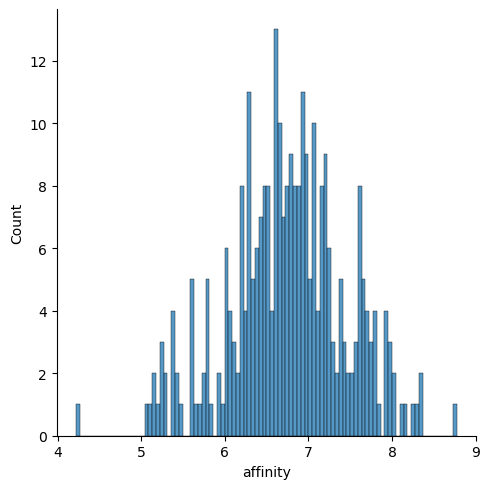

In [38]:
sns.displot(df, x='affinity', bins=100)

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import torch
import dgym as dg
import pyarrow.parquet as pq

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make designer.

In [2]:
import numpy as np
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [20]:
from tqdm.notebook import tqdm

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

random_molecules = []
for _ in tqdm(range(30)):
    
    # pick a molecule randomly from the deck
    initial_molecule = select_molecule(deck)

    # generate a few rounds of random molecules in REAL Space
    molecule = initial_molecule
    designer.reset_cache()
    for _ in range(3):
        molecule = designer.design(molecule, 1, temperature=1.0)[0]
    
    # generate a bunch of analogs
    molecules = designer.design(molecule, 10, temperature=1.0)
    
    random_molecules.extend(molecules)

  0%|          | 0/30 [00:00<?, ?it/s]

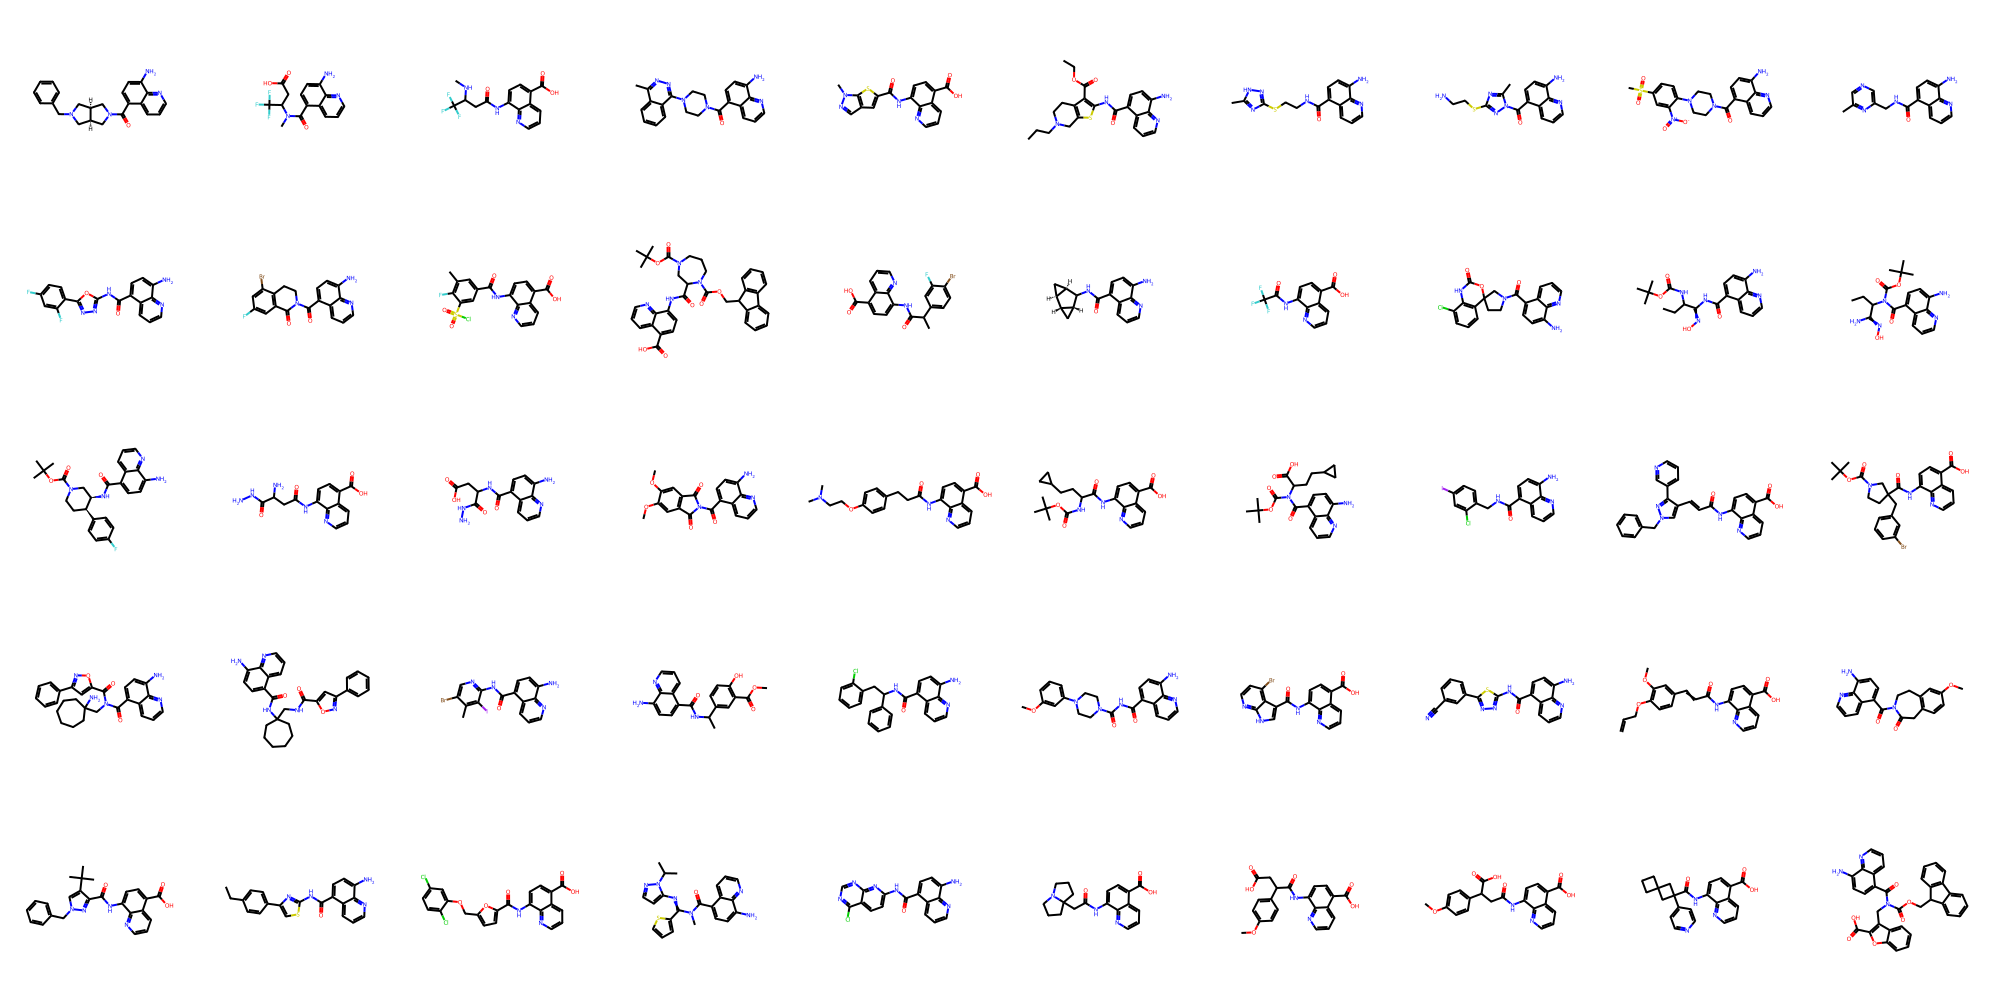

In [11]:
rdkit.Chem.Draw.MolsToGridImage([a.mol for a in random_molecules[9_000:]], molsPerRow=10)

In [19]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

In [22]:
scores = docking_oracle(random_molecules)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


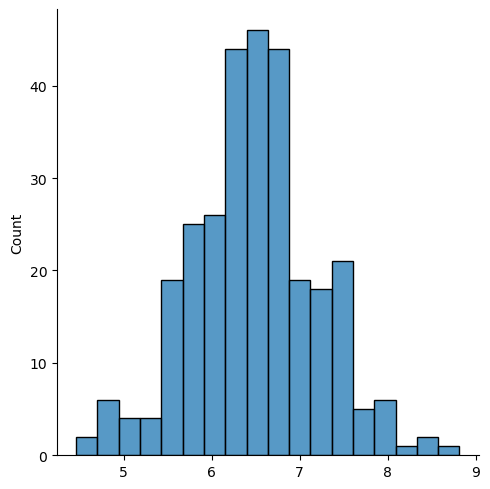

In [24]:
import seaborn as sns

sns.displot(scores)